In [1]:
!pip install -q gensim
!pip install -q markovify
!apt-get -qq install -y graphviz && pip install -q pydot

Extracting templates from packages: 100%
Selecting previously unselected package libxext6:amd64.
(Reading database ... 16633 files and directories currently installed.)
Preparing to unpack .../00-libxext6_2%3a1.3.3-1_amd64.deb ...
Unpacking libxext6:amd64 (2:1.3.3-1) ...
Selecting previously unselected package fontconfig.
Preparing to unpack .../01-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package x11-common.
Preparing to unpack .../02-x11-common_1%3a7.7+19ubuntu3_all.deb ...
Unpacking x11-common (1:7.7+19ubuntu3) ...
Selecting previously unselected package libice6:amd64.
Preparing to unpack .../03-libice6_2%3a1.0.9-2_amd64.deb ...
Unpacking libice6:amd64 (2:1.0.9-2) ...
Selecting previously unselected package libsm6:amd64.
Preparing to unpack .../04-libsm6_2%3a1.2.2-1_amd64.deb ...
Unpacking libsm6:amd64 (2:1.2.2-1) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../05-libjbig0

Setting up libdatrie1:amd64 (0.2.10-5) ...
Setting up libtiff5:amd64 (4.0.8-5) ...
Setting up libgraphite2-3:amd64 (1.3.10-2) ...
Setting up libpixman-1-0:amd64 (0.34.0-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2) ...
Setting up libltdl7:amd64 (2.4.6-2) ...
Setting up libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Setting up libxpm4:amd64 (1:3.5.12-1) ...
Setting up libthai-data (0.1.26-3) ...
Setting up x11-common (1:7.7+19ubuntu3) ...
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libcdt5 (2.38.0-16ubuntu2) ...
Setting up fontconfig (2.11.94-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcgraph6 (2.38.0-16ubuntu2) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libgvpr2 (2.38.0-16ubuntu2) ...
Setting up libgd3:amd64 (2.2.5-3) ...
Setting up libharfbuzz0

# Intro

Today we are going to be looking at a series of text analysis tools, from TFIDF and feature importances from decision trees to text generation and word2vec. We are only skimming the surface, that being said we have a lot to cover, so let's get started!

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
tweets_csv = pd.compat.StringIO(uploaded['tweets.csv'])

df = pd.read_csv(tweets_csv)

User uploaded file "tweets.csv" with length 4902648 bytes


In [0]:
# df = pd.read_csv('./tweets.csv')
df.date = pd.to_datetime(df.date)
df = df[~df.text.str.startswith('rt ')]
df = df[~df.text.str.startswith('RT')]

In [6]:
df.head()

,Unnamed: 0,date,text,author
0,0,2016-10-14,Denying climate change is dangerous. Join @OFA...,BarackObama
1,1,2016-10-14,The American Bar Association gave Judge Garlan...,BarackObama
2,2,2016-10-14,We need a fully functional Supreme Court. Edit...,BarackObama
3,3,2016-10-14,"Cynics, take note: When we #ActOnClimate, we b...",BarackObama
4,4,2016-10-13,"""That’s how we will overcome the challenges we...",BarackObama


In [6]:
df.groupby('author').author.count()

author
BarackObama        9126
DonaldTrump       14310
HillaryClinton     5654
Name: author, dtype: int64

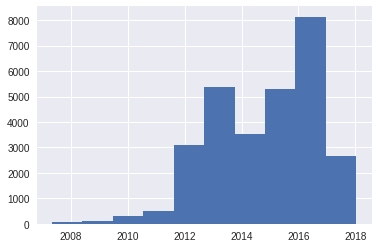

In [7]:
df.date.hist()

## Distinguish between tweet authors

Two approaches:

1. Look for most distinguishing words (aka learn the most important features)
2. Construct features and use a decision tree (aka hand craft features and learn which are the most important)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
def get_most_indicative(author, n=20, min_df=100):
    # make a bag of words of the full text with high freq words
    cv_full = CountVectorizer(min_df=min_df, stop_words='english')
    full_text = cv_full.fit_transform(df.text)
    full_vocab_use = full_text.sum(0).astype('float64')
    
    # make a bag for one author
    df_a  = df[df.author == author]
    a_text = cv_full.transform(df_a.text)
    a_vocab_use = a_text.sum(0).astype('float64')
    
    # find that author's relative word use
    a_relative_vocab_use = a_vocab_use / full_vocab_use
    a_relative_vocab_use = np.array(a_relative_vocab_use).reshape(-1)
    
    # make a dict from index to word
    rev_vocab = dict([ (v, k) for k, v in cv_full.vocabulary_.iteritems( ) ])
    
    # find the most indicative and most used for this author
    a_most_indicative = np.argsort(-a_relative_vocab_use)
    a_most_used = np.argsort(-a_vocab_use)
    
    most_indicative = []
    most_used = []
    for i in range(n):
        mi = (rev_vocab[a_most_indicative[i]], a_vocab_use[0, a_most_indicative[i]], full_vocab_use[0, a_most_indicative[i]])
        most_indicative.append(mi)
        
        mu = (rev_vocab[a_most_used[0, i]], a_vocab_use[0, a_most_used[0, i]], full_vocab_use[0, a_most_used[0, i]])
        most_used.append(mu)
        
    return most_indicative, most_used
        
      

In [10]:
mi, mu = get_most_indicative('BarackObama', n=7)

print 'Most indicative'
print mi

print 'Most used'
print mu

Most indicative
[(u'getcovered', 139.0, 139.0), (u'raisethewage', 117.0, 117.0), (u'ofa', 2724.0, 2724.0), (u'obama2012', 108.0, 108.0), (u'bo', 2622.0, 2623.0), (u'actonclimate', 414.0, 415.0), (u'doyourjob', 168.0, 169.0)]
Most used
[(u'http', 4296.0, 6616.0), (u'president', 3442.0, 4522.0), (u'obama', 3049.0, 4242.0), (u'ofa', 2724.0, 2724.0), (u'bo', 2622.0, 2623.0), (u'com', 1484.0, 4846.0), (u'twitter', 1379.0, 3278.0)]


In [11]:
mi, mu = get_most_indicative('HillaryClinton', n=7)

print 'Most indicative'
print mi

print 'Most used'
print mu

Most indicative
[(u'io', 446.0, 447.0), (u'hrc', 455.0, 461.0), (u'twimg', 547.0, 575.0), (u'flotus', 100.0, 137.0), (u'hillary', 1280.0, 1772.0), (u'status', 151.0, 221.0), (u'rights', 168.0, 252.0)]
Most used
[(u'https', 2517.0, 5469.0), (u'com', 1908.0, 4846.0), (u'twitter', 1286.0, 3278.0), (u'hillary', 1280.0, 1772.0), (u'trump', 1118.0, 2488.0), (u'pic', 870.0, 2146.0), (u'amp', 673.0, 1144.0)]


In [12]:
mi, mu = get_most_indicative('DonaldTrump', n=7)

print 'Most indicative'
print mi

print 'Most used'
print mu

Most indicative
[(u'cont', 253.0, 253.0), (u'makeamericagreatagain', 141.0, 141.0), (u'crooked', 210.0, 210.0), (u'celebrity', 116.0, 116.0), (u'foxandfriends', 131.0, 131.0), (u'trump2016', 109.0, 109.0), (u'foxnews', 154.0, 154.0)]
Most used
[(u'great', 1894.0, 2136.0), (u'http', 1766.0, 6616.0), (u'https', 1688.0, 5469.0), (u'com', 1454.0, 4846.0), (u'trump', 1370.0, 2488.0), (u'obama', 1130.0, 4242.0), (u'just', 1053.0, 1673.0)]


# Decision Tree and Visualization 

Preprocessing - by hand

- lowercase
- rid special chars (except #)
- rid punctuation
- rid stop words
- remove links

Feature Engineering and Classification with Sklearn 

- create bigrams and unigrams
- remove words occuring < 3 times
- remove terms in 25% of all docs



In [13]:
import string
punc = string.punctuation.replace('#', '')
punc = punc.replace('@', '')
# punc += '—'
# punc += '”'
# punc += '“' 
# punc += '…' 
# punc += '‘'

punc

'!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'

In [0]:
def preprocess(x): 
    x = x.lower()
    #replace links 
    for word in x.split(): 
        if 'pic.twitter' in word:
            x = x.replace(word, '')
        if 'http' in word: 
            x = x.replace(word, '') 
    #replace special chars 
    for char in punc: 
        x = x.replace(char, '')
    x = ' '.join(x.split()) #get rid of white spaces 

    return x
    
df['process_text'] = df.text.apply(preprocess)

In [15]:
print (df.shape)
df.head(2)

(29090, 5)


,Unnamed: 0,date,text,author,process_text
0,0,2016-10-14,Denying climate change is dangerous. Join @OFA...,BarackObama,denying climate change is dangerous join @ofa ...
1,1,2016-10-14,The American Bar Association gave Judge Garlan...,BarackObama,the american bar association gave judge garlan...


In [16]:
### word counts ### 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

cvec = CountVectorizer(stop_words='english', min_df=4, max_df=.25, ngram_range=(1,2))
cvec.fit(df.process_text)
cvec_counts = cvec.transform(df.process_text)
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head()

,occurrences,term
9159,4361,president
8064,3934,obama
9196,2892,president obama
4954,2092,great
12123,1990,trump


In [17]:
top_terms = counts_df.sort_values(by='occurrences', ascending=False)[:100].term.values

def generate_features(text): 
    one_hot = np.zeros(shape=top_terms.shape, dtype=int)
    for i, term in enumerate(top_terms): 
        for word in text.split(): 
            if word == term:
                one_hot[i] = 1
    return one_hot

temp = df.process_text.apply(generate_features)
temp = temp.apply(lambda x: pd.Series(x)) #split the vector into columns 
temp.columns = top_terms #rename 
df_feat = df.join(temp) 
df_feat.head(1) #spot check

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  import sys


,Unnamed: 0,date,text,author,process_text,president,obama,president obama,great,trump,...,don,romney,youre,house,bad,join,did,potus,making,republicans
0,0,2016-10-14,Denying climate change is dangerous. Join @OFA...,BarackObama,denying climate change is dangerous join @ofa ...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0



Decision Tree + Visualization

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

df_TREE = df_feat #[df_feat.author != 'HillaryClinton']

### Cross Val Decision Tree ### 
# clf = tree.DecisionTreeClassifier(random_state=0)
# scores = cross_val_score(clf, df_TREE.iloc[:, 4:], df_TREE.author, cv=10)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# print (scores)

### Decision Tree for Visualization ###

split =  int(df_TREE.shape[0]* 0.9)

clf = tree.DecisionTreeClassifier(random_state=0, 
                                 max_depth=3, #low for visibility 
                                 criterion = 'entropy')

clf = clf.fit(X = df_TREE.iloc[:split, 5:],
              y = df_TREE.author[:split])

### Visualize ###
dotfile = open("dtree2.dot", 'w')
tree.export_graphviz(clf, out_file = dotfile, feature_names = df_TREE.iloc[:, 5:].columns)
dotfile.close()

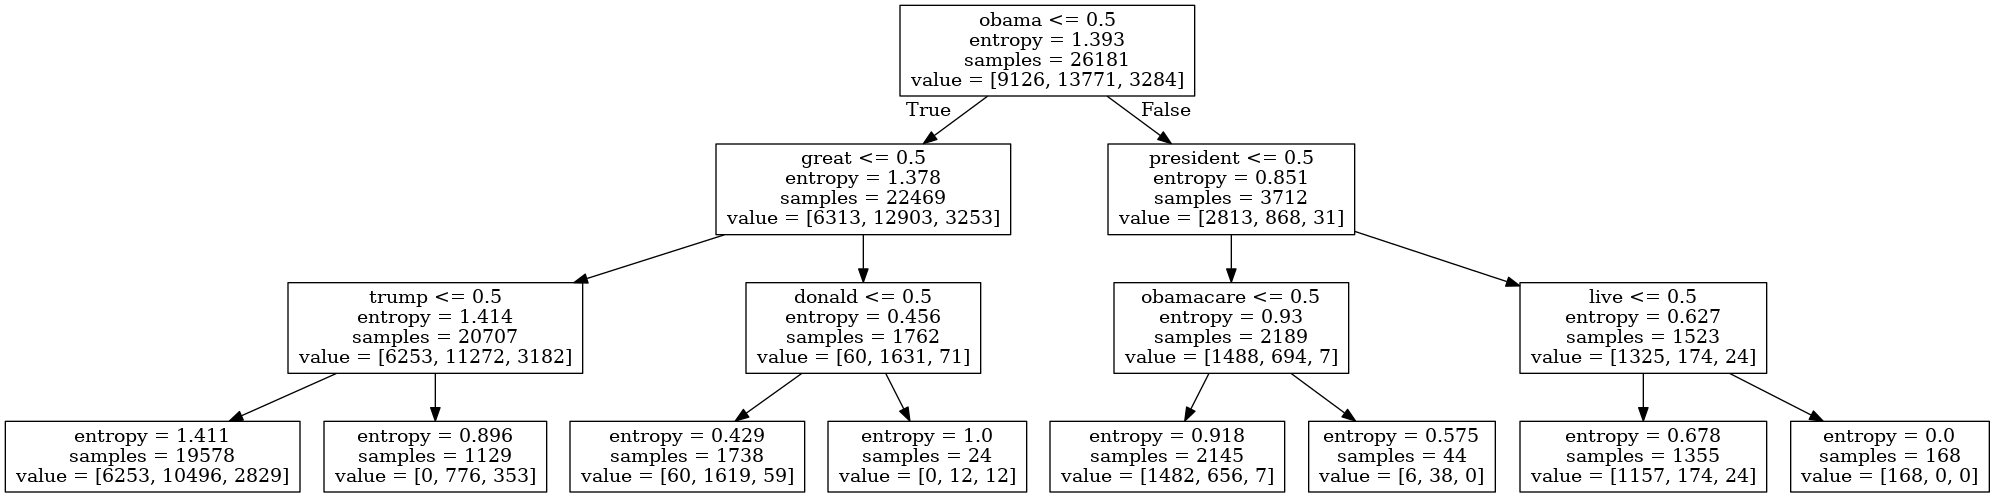

In [19]:
import pydot
from IPython.display import Image 

(graph,) = pydot.graph_from_dot_file('dtree2.dot')
graph.write_png('tree.png')

Image(filename='tree.png')

## Test generation

Let's try to generate some text in the style of the authors. We will try two approaches:

1. A markov model

In [0]:
import markovify

In [0]:
def model_author(author):

    df_author  = df[df.author == author]
    author_text = '.'.join(df_author.text.tolist())
    
    text_model = markovify.Text(author_text)
    return text_model

In [22]:
obama_bot = model_author('BarackObama')

for i in range(3):
    print(obama_bot.make_short_sentence(140))

Watch live: http://wh.gov/live .Ever wonder what a consensus looks like.
#ACA.FACT: President Obama’s last birthday in office extra special.
The President has done for us.


In [23]:
trump_bot = model_author('DonaldTrump')

for i in range(3):
    print(trump_bot.make_short_sentence(140))

People haven't had a chance.
Buy directly from CBS Evening News..At some point the Fake News or politically motivated ingrates,....19,000 RESPECTING our National Anthem.
Must be very exciting!.Honored to serve as the capital gains tax in this week’s All-Star Celebrity Apprentice..Enviro friendly?


In [24]:
clinton_bot = model_author('HillaryClinton')

for i in range(3):
    print(clinton_bot.make_short_sentence(140))

They can't wait to see how you can vote in 2002 is not an occasion for politics as usual.
Why that should terrify you:http://hrc.io/1lYxYEf .Keeping our families and communities. -H.Hats off to care for 9 million children expire.
Tolerance is on the border and call for treating American Muslims in New York state like I do, there are none.


## Word2Vec
* Trains a two-layer neural network to generate dense vector representations of words (*word embeddings*)
* Two main versions:
  * **continuous bag of words** (*CBOW*): use context words to predict target word
  * **skip-gram model**: use target word to predict context words
![](https://raw.githubusercontent.com/andrewdblevins/beyond_word2vec/master/images/Word2vec2.png =800x)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

tokenize_text = CountVectorizer(
    stop_words='english', 
    lowercase=True,
    token_pattern=r'\b\w*[a-zA-Z]{3,}\w*\b'
).build_analyzer()

df['text_tokens'] = df.text.apply(lambda x: tokenize_text(x))

In [87]:
df[['text', 'text_tokens']].head()

,text,text_tokens
0,Denying climate change is dangerous. Join @OFA...,"[denying, climate, change, dangerous, join, of..."
1,The American Bar Association gave Judge Garlan...,"[american, bar, association, gave, judge, garl..."
2,We need a fully functional Supreme Court. Edit...,"[need, fully, functional, supreme, court, edit..."
3,"Cynics, take note: When we #ActOnClimate, we b...","[cynics, note, actonclimate, build, stronger, ..."
4,"""That’s how we will overcome the challenges we...","[overcome, challenges, face, unleashing, power..."


In [0]:
from gensim.models import Word2Vec

authors = ['BarackObama', 'DonaldTrump', 'HillaryClinton']
w2v_models = {}

for author in authors:
  w2v_models[author] = Word2Vec(
      sentences=df.text_tokens[df.author == author]
  )

In [116]:
topn = 3
topics = ['health', 'america', 'china', 'women',
          'important', 'support', 'lgbt',
          'trump', 'obama', 'clinton']

for topic in topics:
    print('\n --- Topic: %s --- \n' % topic)
    for author, w2v_model in w2v_models.items():
        print('%s:' % author)
        try:
            similar_words = w2v_model.wv.similar_by_word(topic, topn=topn)
        except KeyError:
            similar_words = ['UNDEFINED']
        print(similar_words)


 --- Topic: health --- 

HillaryClinton:
[(u'access', 0.9997118711471558), (u'child', 0.9996848702430725), (u'affordable', 0.999656617641449)]
DonaldTrump:
[(u'private', 0.9998042583465576), (u'send', 0.9998011589050293), (u'victims', 0.9997828006744385)]
BarackObama:
[(u'affordable', 0.9978976845741272), (u'care', 0.9911826848983765), (u'reform', 0.9900367259979248)]

 --- Topic: america --- 

HillaryClinton:
[(u'great', 0.9998519420623779), (u'work', 0.9998313188552856), (u'strong', 0.999828577041626)]
DonaldTrump:
[(u'great', 0.9723272323608398), (u'make', 0.9686092138290405), (u'thank', 0.9381998181343079)]
BarackObama:
[(u'opportunityforall', 0.9993357062339783), (u'want', 0.9991331696510315), (u'education', 0.9990577697753906)]

 --- Topic: china --- 

HillaryClinton:
[(u'world', 0.9996312856674194), (u'help', 0.9996302723884583), (u'potus', 0.9996299147605896)]
DonaldTrump:
[(u'iran', 0.9992865324020386), (u'killing', 0.9989791512489319), (u'laughing', 0.998968243598938)]
Barac

# Conclusion

More things that we could do if we had time:

1. LSTM generative model
2. LDA, to extract topics of the tweets
3. Sentiment analysis
4. TweetResponderBot!!!
5. Do stuff with likes and retweets (predict or use as predictors)